***Note: Google Colab has been used to run the the file***

# WHY FAKE NEWS IS A PROBLEM?
**Fake news refers to misinformation, disinformation or mal-information which is spread through word of mouth and traditional media and more recently through digital forms of communication such as edited videos, memes, unverified advertisements and social media propagated rumours.Fake news spread through social media has become a serious problem, with the potential of it resulting in mob violence, suicides etc as a result of misinformation circulated on social media.**
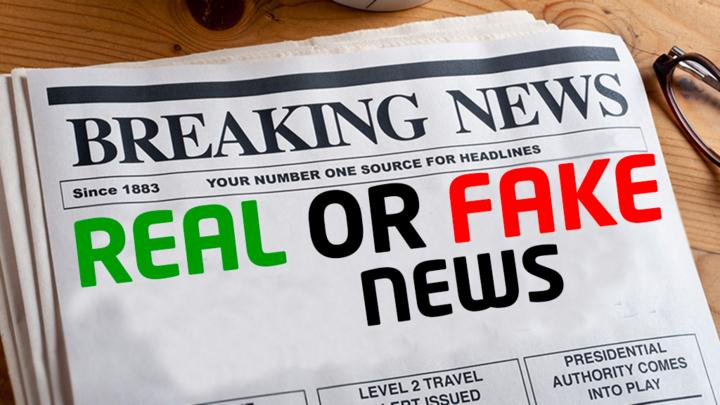

In [ ]:
import nltk
nltk.download('stopwords')

## STEP 1: Import necessary libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud, STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from bs4 import BeautifulSoup
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from keras.preprocessing import text, sequence
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.callbacks import ReduceLROnPlateau

## STEP 2: Load the dataset
- The dataset is stored in the Google Drive folder (news) with two files (True.csv & Fake.csv).

#### **BRIEF DESCRIPTION OF DATASET**
This dataset consists of about 40000 articles consisting of fake as well as real news. Our aim is train our model so that it can correctly predict whether a given piece of news is real or fake.The fake and real news data is given in two separate datasets with each dataset consisting around 20000 articles each.


In [ ]:
true = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/news/True.csv")
false = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/news/Fake.csv")

In [ ]:
true.head()

In [ ]:
false.head()

## STEP 3: Combine the datasets

In [ ]:
true['category'] = 1
false['category'] = 0
df = pd.concat([true, false])

In [ ]:
df.isnull().sum()

## STEP 4: Clean the data

In [ ]:
def clean_text(text):
    text = BeautifulSoup(text, "html.parser").get_text()
    text = re.sub(r'http\S+', '', text)
    stop = set(stopwords.words('english'))
    punctuation = list(string.punctuation)
    stop.update(punctuation)
    final_text = []
    for word in text.split():
        if word.strip().lower() not in stop:
            final_text.append(word.strip())
    cleaned_text = " ".join(final_text)

    # Check if the cleaned text is empty
    if not cleaned_text:
        cleaned_text = "placeholder"  # Add a placeholder word

    return cleaned_text

df['clean_text'] = df['text'].apply(clean_text)

## STEP 5: Word cloud for real and fake text


In [ ]:
# Word cloud for real and fake text
def plot_wordcloud(category):
    wc = WordCloud(max_words=2000, width=1600, height=800, stopwords=STOPWORDS).generate(" ".join(df[df.category == category].clean_text))
    plt.imshow(wc, interpolation='bilinear')
    plt.show()

# Plot word cloud for real text
plot_wordcloud(1)

# Plot word cloud for fake text
plot_wordcloud(0)


## STEP 6: Split the data into training and testing sets

In [ ]:

x_train, x_test, y_train, y_test = train_test_split(df.clean_text, df.category, random_state=0)

## STEP 7: Tokenizing text and padding sequences

In [ ]:
max_features = 10000
maxlen = 300
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train)
tokenized_train = tokenizer.texts_to_sequences(x_train)
x_train = sequence.pad_sequences(tokenized_train, maxlen=maxlen)
tokenized_test = tokenizer.texts_to_sequences(x_test)
x_test = sequence.pad_sequences(tokenized_test, maxlen=maxlen)

In [ ]:
def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype='float32')

# Step 11: Load pre-trained GloVe embeddings
EMBEDDING_FILE = '/content/drive/MyDrive/Colab Notebooks/news/glove.twitter.27B.100d.txt'

def load_embeddings(embedding_file, word_index, max_features):
    embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(embedding_file, encoding='utf-8'))
    all_embs = np.stack(embeddings_index.values())
    emb_mean, emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]

    nb_words = min(max_features, len(word_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= max_features:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    return embedding_matrix, embed_size

embedding_matrix, embed_size = load_embeddings(EMBEDDING_FILE, tokenizer.word_index, max_features)

## STEP 8: Model definition and training

In [ ]:
batch_size = 256
epochs = 3
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.5, min_lr=0.00001)

model = Sequential()
model.add(Embedding(max_features, output_dim=embed_size, weights=[embedding_matrix], input_length=maxlen, trainable=False))
model.add(LSTM(units=128, return_sequences=True, recurrent_dropout=0.25, dropout=0.25))
model.add(LSTM(units=64, recurrent_dropout=0.1, dropout=0.1))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(x_train, y_train, batch_size=batch_size, validation_data=(x_test, y_test), epochs=epochs, callbacks=[learning_rate_reduction])


## STEP 9: Model evaluation and analysis

In [ ]:
print("Accuracy on Training Data:", model.evaluate(x_train, y_train)[1] * 100, "%")
print("Accuracy on Testing Data:", model.evaluate(x_test, y_test)[1] * 100, "%")

In [ ]:
# Get the actual number of epochs from the history object
actual_epochs = len(history.history['accuracy'])

epochs = [i for i in range(actual_epochs)]  # Adjust epochs array based on the actual number of epochs
fig, ax = plt.subplots(1, 2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20, 10)

ax[0].plot(epochs, train_acc, 'go-', label='Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label='Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, 'go-', label='Training Loss')
ax[1].plot(epochs, val_loss, 'ro-', label='Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")

plt.show()

## Step 10: Confusion Matrix and Classification Report

In [ ]:
# Use predict method to get predicted probabilities
pred_probabilities = model.predict(x_test)

# Threshold predicted probabilities to get predicted classes
pred = (pred_probabilities > 0.5).astype('int32')

print(classification_report(y_test, pred, target_names=['Fake', 'Not Fake']))
cm = confusion_matrix(y_test, pred)
cm = pd.DataFrame(cm, index=['Fake', 'Original'], columns=['Fake', 'Original'])

plt.figure(figsize=(10, 10))
sns.heatmap(cm, cmap="Blues", linecolor='black', linewidth=1, annot=True, fmt='', xticklabels=['Fake', 'Original'], yticklabels=['Fake', 'Original'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
